<a href="https://colab.research.google.com/github/Dp20032/Neuromatch_BrainCancer/blob/main/Copy_of_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display
import os
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 70 bytes


In [ ]:
!kaggle datasets download -d vbookshelf/respiratory-sound-database

100% 3.67G/3.69G [01:00<00:00, 89.9MB/s]
100% 3.69G/3.69G [01:00<00:00, 64.9MB/s]


In [ ]:
!unzip respiratory-sound-database.zip

Archive:  respiratory-sound-database.zip
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.txt  
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.wav  
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.txt  
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.wav  
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/102_1b1_Ar_sc_Meditron.txt  
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/102_1b1_Ar_sc_Meditron.wav  
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/103_2b2_Ar_mc_LittC2SE.txt  
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/103_2b2_Ar_mc_LittC2SE.wav  
  inflating: Respiratory_Sound_

In [ ]:
diagnosis=pd.read_csv("/content/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv", names=['pid','disease'])
path="/content/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/"
files=[s.split('.')[0] for s in os.listdir(path) if '.txt' in s]
files[:5]

['160_2b4_Pl_mc_AKGC417L',
 '138_1p3_Pr_mc_AKGC417L',
 '194_1b1_Lr_sc_Meditron',
 '181_1b1_Tc_mc_LittC2SE',
 '176_1b4_Ll_mc_AKGC417L']

In [ ]:
def getFilenameInfo(file):
    return file.split('_')

In [ ]:
files_data=[]
for file in files:
    data=pd.read_csv(path + file + '.txt',sep='\t',names=['start','end','crackles','weezels'])
    name_data=getFilenameInfo(file)
    data['pid']=name_data[0]
    data['mode']=name_data[-2]
    data['filename']=file
    files_data.append(data)
files_df=pd.concat(files_data)
files_df.reset_index()
files_df.head()

,start,end,crackles,weezels,pid,mode,filename
0,1.945,4.716,1,0,160,mc,160_2b4_Pl_mc_AKGC417L
1,4.716,7.337,1,0,160,mc,160_2b4_Pl_mc_AKGC417L
2,7.337,9.942,1,0,160,mc,160_2b4_Pl_mc_AKGC417L
3,9.942,12.613,1,0,160,mc,160_2b4_Pl_mc_AKGC417L
4,12.613,15.301,1,0,160,mc,160_2b4_Pl_mc_AKGC417L


In [ ]:
diagnosis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   pid      126 non-null    int64 
 1   disease  126 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


In [ ]:
files_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6898 entries, 0 to 9
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   start     6898 non-null   float64
 1   end       6898 non-null   float64
 2   crackles  6898 non-null   int64  
 3   weezels   6898 non-null   int64  
 4   pid       6898 non-null   object 
 5   mode      6898 non-null   object 
 6   filename  6898 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 431.1+ KB


In [ ]:
diagnosis.pid=diagnosis.pid.astype('int32')
files_df.pid=files_df.pid.astype('int32')

In [ ]:
data=pd.merge(files_df,diagnosis,on='pid')


In [ ]:
os.makedirs('csv_data')
data.to_csv('csv_data/data.csv',index=False)

In [ ]:
def getPureSample(raw_data,start,end,sr=22050):
    '''
    Takes a numpy array and spilts its using start and end args

    raw_data=numpy array of audio sample
    start=time
    end=time
    sr=sampling_rate
    mode=mono/stereo

    '''
    max_ind = len(raw_data)
    start_ind = min(int(start * sr), max_ind)
    end_ind = min(int(end * sr), max_ind)
    return raw_data[start_ind: end_ind]

In [ ]:
os.makedirs('processed_audio_files')

In [ ]:
for index,row in data.iterrows():
    print("Index ->",index)
    print("Data->\n",row)
    break

Index -> 0
Data->
 start                        1.945
end                          4.716
crackles                         1
weezels                          0
pid                            160
mode                            mc
filename    160_2b4_Pl_mc_AKGC417L
disease                       COPD
Name: 0, dtype: object


In [ ]:
import librosa as lb
import soundfile as sf
i,c=0,0
for index,row in data.iterrows():
    maxLen=6
    start=row['start']
    end=row['end']
    filename=row['filename']

    #If len > maxLen , change it to maxLen
    if end-start>maxLen:
        end=start+maxLen

    audio_file_loc=path + filename + '.wav'

    if index > 0:
        #check if more cycles exits for same patient if so then add i to change filename
        if data.iloc[index-1]['filename']==filename:
            i+=1
        else:
            i=0
    filename= filename + '_' + str(i) + '.wav'

    save_path='processed_audio_files/' + filename
    c+=1

    audioArr,sampleRate=lb.load(audio_file_loc)
    pureSample=getPureSample(audioArr,start,end,sampleRate)

    #pad audio if pureSample len < max_len
    reqLen=6*sampleRate
    padded_data = lb.util.pad_center(data= pureSample,size= reqLen)

    sf.write(file=save_path,data=padded_data,samplerate=sampleRate)
print('Total Files Processed: ',c)

Total Files Processed:  6898


In [ ]:
import shutil
import os

# Define source folder
source_folder = '/content/processed_audio_files'

# Zip the folder
shutil.make_archive('/content/processed_audio_files', 'zip', source_folder)

# Move the zip file to the content directory
shutil.move('/content/processed_audio_files.zip', '/content/processed_audio_files.zip')

# Provide download link for the zip file
print("Download the zip file: ", '/content/processed_audio_files.zip')


Download the zip file:  /content/processed_audio_files.zip


In [ ]:
demographics = pd.read_csv("/content/demographic_info.txt", delimiter='\s+', names=['pid','age', "sex", 'bmi','weight', 'height'] )
demographic_features= demographics[["pid", "age", "sex"]]

In [ ]:
demographic_features.iloc[122,1]=43
demographic_features.iloc[122,2]= "M"

In [ ]:
demographic_features["Sex"]=np.array(demographic_features["sex"]=="M").astype(int)
demographic_features= demographic_features.drop(["sex"], axis=1)

<ipython-input-20-73d2e40fd5db>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demographic_features["Sex"]=np.array(demographic_features["sex"]=="M").astype(int)


In [ ]:
def extractId(filename):
    return filename.split('_')[0]

In [ ]:
path='/content/processed_audio_files'
length=len(os.listdir(path))
index=range(length)
i=0
files_df=pd.DataFrame(index=index,columns=['pid','filename'])
for f in os.listdir(path):
    files_df.iloc[i]['pid']=extractId(f)
    files_df.iloc[i]['filename']=f
    i+=1

In [ ]:
demographic_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pid     126 non-null    int64  
 1   age     126 non-null    float64
 2   Sex     126 non-null    int64  
dtypes: float64(1), int64(2)
memory usage: 3.1 KB


In [ ]:
files_df.pid=files_df.pid.astype('int64')


In [ ]:
data=pd.merge(files_df,demographic_features,on='pid')
data= pd.merge(data,diagnosis,on='pid')
data['age'] = (data['age'] - data['age'].min()) / (data['age'].max() - data['age'].min())
data

,pid,filename,age,Sex,disease
0,140,140_2b3_Tc_mc_LittC2SE_1.wav,0.849057,0,Pneumonia
1,140,140_2b2_Tc_mc_LittC2SE_8.wav,0.849057,0,Pneumonia
2,140,140_2b2_Ll_mc_LittC2SE_10.wav,0.849057,0,Pneumonia
3,140,140_2b3_Tc_mc_LittC2SE_0.wav,0.849057,0,Pneumonia
4,140,140_2b3_Tc_mc_LittC2SE_3.wav,0.849057,0,Pneumonia
...,...,...,...,...,...
6893,128,128_1b3_Tc_mc_LittC2SE_2.wav,0.698113,0,COPD
6894,128,128_1b3_Tc_mc_LittC2SE_4.wav,0.698113,0,COPD
6895,128,128_1b3_Tc_mc_LittC2SE_1.wav,0.698113,0,COPD
6896,128,128_1b3_Tc_mc_LittC2SE_3.wav,0.698113,0,COPD


In [ ]:
from sklearn.model_selection import train_test_split
Xtrain,Xval,ytrain,yval=train_test_split(data,data.disease,stratify=data.disease,random_state=42,test_size=0.20)

In [ ]:

X_binary_train= Xtrain[["age", "Sex"]]
X_binary_val= Xval[["age", "Sex"]]

In [ ]:
from keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Encode the string labels into integer values
ytrain_encoded = label_encoder.fit_transform(ytrain)
yval_encoded = label_encoder.transform(yval)


num_classes=8
# Perform one-hot encoding on the encoded labels
ytrain = to_categorical(ytrain_encoded, num_classes)
yval = to_categorical(yval_encoded, num_classes)

In [ ]:
def getFeatures(path):
    soundArr,sample_rate=lb.load(path)
    mfcc=lb.feature.mfcc(y=soundArr,sr=sample_rate)
    cstft=lb.feature.chroma_stft(y=soundArr,sr=sample_rate)
    mSpec=lb.feature.melspectrogram(y=soundArr,sr=sample_rate)

    return mfcc,cstft,mSpec

In [ ]:
root='/content/processed_audio_files/'
mfcc,cstft,mSpec=[],[],[]

for idx,row in Xval.iterrows():
    path=root + row['filename']
    a,b,c=getFeatures(path)
    mfcc.append(a)
    cstft.append(b)
    mSpec.append(c)

mfcc_val=np.array(mfcc)
cstft_val=np.array(cstft)
mSpec_val=np.array(mSpec)

/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [ ]:
root='/content/processed_audio_files/'
mfcc,cstft,mSpec=[],[],[]

for idx,row in Xtrain.iterrows():
    path=root + row['filename']
    a,b,c=getFeatures(path)
    mfcc.append(a)
    cstft.append(b)
    mSpec.append(c)

mfcc_train=np.array(mfcc)
cstft_train=np.array(cstft)
mSpec_train=np.array(mSpec)

In [ ]:
audio_input_shape= mfcc_train.shape[1], mfcc_train.shape[2]
binary_input_shape= 2

In [ ]:
import tensorflow.keras.layers as layers
import tensorflow as tf
from tensorflow.keras import layers


# Reshape the input data to have 4D shape
audio_input_shape= (mfcc_train.shape[1], mfcc_train.shape[2])
binary_input_shape= 2
num_channels = 1  # Number of audio channels

audio_model = tf.keras.Sequential([
    layers.Reshape(target_shape=(*audio_input_shape, num_channels), input_shape=audio_input_shape),
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.1),

    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(1, 2)),
    layers.Dropout(0.1),

    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(1, 2)),

    layers.Flatten()
])

binary_input_shape = (binary_input_shape,)  # Example shape, adjust according to your data
binary_model = tf.keras.Sequential([
    layers.Dense(32, activation="relu", input_shape=binary_input_shape)
])

audio_input = tf.keras.Input(shape=audio_input_shape)
binary_input = tf.keras.Input(shape=binary_input_shape)

combined = layers.Concatenate()([audio_model(audio_input), binary_model(binary_input)])
combined = layers.Dense(32, activation="relu")(combined)
combined= layers.Dropout(0.1)(combined)
output = layers.Dense(8, activation="softmax")(combined)

combined_model = tf.keras.Model(inputs=[audio_input, binary_input], outputs=output)

# Print model summary
combined_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 259)]    0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 sequential (Sequential)        (None, 9600)         56384       ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 32)           96          ['input_2[0][0]']                
                                                                                              

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

Epoch 1/10
173/173 [==============================] - 73s 403ms/step - loss: 0.5969 - accuracy: 0.8229 - val_loss: 0.8101 - val_accuracy: 0.6601
Epoch 2/10
173/173 [==============================] - 73s 425ms/step - loss: 0.3691 - accuracy: 0.8701 - val_loss: 0.3521 - val_accuracy: 0.8732
Epoch 3/10
173/173 [==============================] - 70s 404ms/step - loss: 0.3055 - accuracy: 0.8900 - val_loss: 0.3080 - val_accuracy: 0.9072
Epoch 4/10
173/173 [==============================] - 69s 398ms/step - loss: 0.2533 - accuracy: 0.9107 - val_loss: 0.3248 - val_accuracy: 0.8841
Epoch 5/10
173/173 [==============================] - 72s 419ms/step - loss: 0.2184 - accuracy: 0.9224 - val_loss: 0.2279 - val_accuracy: 0.9290
Epoch 6/10
173/173 [==============================] - 69s 397ms/step - loss: 0.1848 - accuracy: 0.9319 - val_loss: 0.2881 - val_accuracy: 0.9167
Epoch 7/10
173/173 [==============================] - 68s 392ms/step - loss: 0.1536 - accuracy: 0.9485 - val_loss: 0.3087 - val_ac

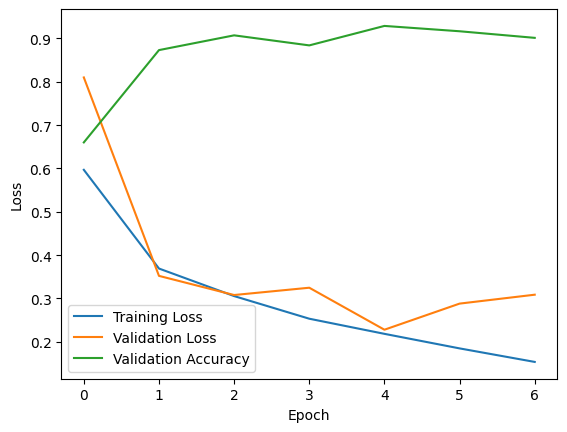

In [ ]:
combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history= combined_model.fit([mfcc_train, X_binary_train], ytrain, epochs=10, batch_size=32, validation_data=([mfcc_val, X_binary_val], yval), callbacks=[early_stopping])



# Plot the training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
combined_model.save("respiratory_model.h5")

In [ ]:
audio_model1 = tf.keras.Sequential([
    layers.Reshape(target_shape=(*audio_input_shape, num_channels), input_shape=audio_input_shape),
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.1),

    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(1, 2)),
    layers.Dropout(0.1),

    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(1, 2)),

    layers.Flatten(),

    layers.Dense(32, activation= "relu"),
    layers.Dense(8, activation= "softmax")


])


Epoch 1/10
173/173 [==============================] - 74s 416ms/step - loss: 0.5650 - accuracy: 0.8306 - val_loss: 0.5512 - val_accuracy: 0.8428
Epoch 2/10
173/173 [==============================] - 71s 409ms/step - loss: 0.3971 - accuracy: 0.8557 - val_loss: 0.3807 - val_accuracy: 0.8580
Epoch 3/10
173/173 [==============================] - 70s 405ms/step - loss: 0.3247 - accuracy: 0.8793 - val_loss: 0.3217 - val_accuracy: 0.8775
Epoch 4/10
173/173 [==============================] - 77s 442ms/step - loss: 0.2877 - accuracy: 0.8918 - val_loss: 0.3262 - val_accuracy: 0.8754
Epoch 5/10
173/173 [==============================] - 73s 421ms/step - loss: 0.2738 - accuracy: 0.8960 - val_loss: 0.3042 - val_accuracy: 0.8920
Epoch 6/10
173/173 [==============================] - 71s 409ms/step - loss: 0.2374 - accuracy: 0.9085 - val_loss: 0.3102 - val_accuracy: 0.9000
Epoch 7/10
173/173 [==============================] - 71s 411ms/step - loss: 0.2010 - accuracy: 0.9239 - val_loss: 0.4390 - val_ac

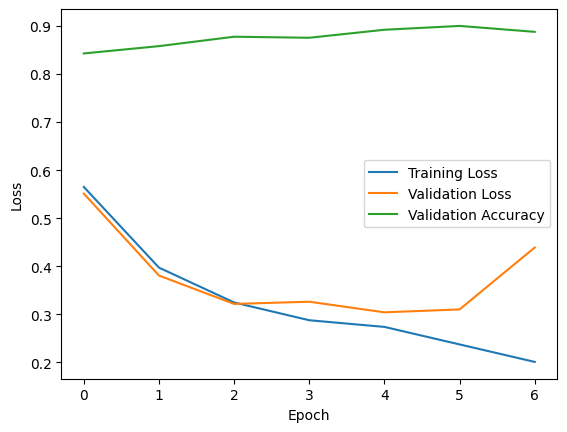

In [ ]:
audio_model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history1= audio_model1.fit(mfcc_train, ytrain, epochs=10, batch_size=32, validation_data=(mfcc_val, yval), callbacks=[early_stopping])



# Plot the training loss and validation loss
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.plot(history1.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
audio_input_shape= (mfcc_train.shape[1], mfcc_train.shape[2])
binary_input_shape= 2
num_channels = 1  # Number of audio channels


audio_model = tf.keras.Sequential([
    layers.Reshape(target_shape=(*audio_input_shape, num_channels), input_shape=audio_input_shape),
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.1),

    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(1, 2)),
    layers.Dropout(0.1),

    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(1, 2)),

    layers.Flatten()
])

binary_input_shape = (binary_input_shape,)  # Example shape, adjust according to your data
binary_model = tf.keras.Sequential([
    layers.Dense(32, activation="relu", input_shape=binary_input_shape)
])

audio_input = tf.keras.Input(shape=audio_input_shape)
binary_input = tf.keras.Input(shape=binary_input_shape)

combined = layers.Concatenate()([audio_model(audio_input), binary_model(binary_input)])
combined = layers.Dense(32, activation="relu")(combined)
combined= layers.Dropout(0.1)(combined)
output = layers.Dense(8, activation="softmax")(combined)

combined_model = tf.keras.Model(inputs=[audio_input, binary_input], outputs=output)

# Print model summary
combined_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 20, 259)]    0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 sequential_3 (Sequential)      (None, 9600)         56384       ['input_3[0][0]']                
                                                                                                  
 sequential_4 (Sequential)      (None, 32)           96          ['input_4[0][0]']                
                                                                                            

Epoch 1/10
173/173 [==============================] - 66s 371ms/step - loss: 0.6106 - accuracy: 0.8229
Epoch 2/10
173/173 [==============================] - 65s 378ms/step - loss: 0.4298 - accuracy: 0.8420
Epoch 3/10
173/173 [==============================] - 64s 369ms/step - loss: 0.3817 - accuracy: 0.8610
Epoch 4/10
173/173 [==============================] - 65s 374ms/step - loss: 0.3484 - accuracy: 0.8721
Epoch 5/10
173/173 [==============================] - 65s 379ms/step - loss: 0.2993 - accuracy: 0.8933
Epoch 6/10
173/173 [==============================] - 64s 372ms/step - loss: 0.2872 - accuracy: 0.8989
Epoch 7/10
173/173 [==============================] - 64s 370ms/step - loss: 0.2602 - accuracy: 0.9050
Epoch 8/10
173/173 [==============================] - 64s 370ms/step - loss: 0.2508 - accuracy: 0.9146
Epoch 9/10
173/173 [==============================] - 66s 379ms/step - loss: 0.2279 - accuracy: 0.9183
Epoch 10/10
173/173 [==============================] - 63s 366ms/step - l

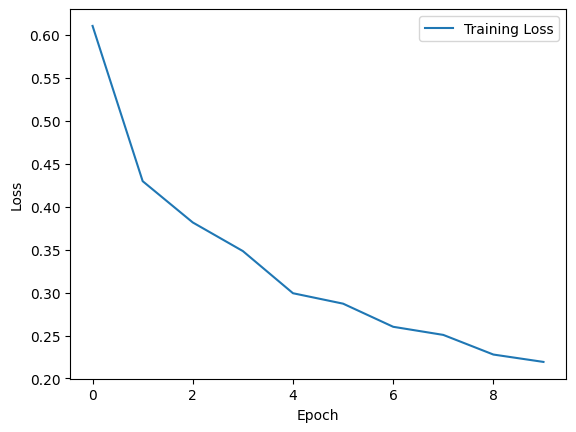

In [ ]:
combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history= combined_model.fit([mfcc_train, X_binary_train], ytrain, epochs=10, batch_size=32)



# Plot the training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.metrics import Precision, Recall



# Get the model predictions on the test set
y_pred_prob = combined_model.predict([mfcc_val, X_binary_val])
y_pred = tf.where(y_pred_prob >= 0.5, 1, 0)

# Assuming you have the one-hot encoded labels yval and the label encoder object label_encoder

# Convert one-hot encoded labels to integer indices
ypred_indices = np.argmax(y_pred, axis=1)

# Inverse transform the integer indices back to the original string labels
y_pred_decoded = label_encoder.inverse_transform(ypred_indices)

# Print the original string labels
print(y_pred_decoded)

# Calculate precision, recall, and F1 score
precision = Precision()(yval, y_pred)
recall = Recall()(yval, y_pred)

def f1_score(y_true, y_pred):
    true_positives = tf.keras.metrics.TruePositives()(y_true, y_pred)
    false_positives = tf.keras.metrics.FalsePositives()(y_true, y_pred)
    false_negatives = tf.keras.metrics.FalseNegatives()(y_true, y_pred)

    precision = true_positives / (true_positives + false_positives + tf.keras.backend.epsilon())
    recall = true_positives / (true_positives + false_negatives + tf.keras.backend.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1
f1= f1_score(yval, y_pred)

# Print the evaluation metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

44/44 [==============================] - 3s 72ms/step
Precision: tf.Tensor(0.9813916, shape=(), dtype=float32)
Recall: tf.Tensor(0.8789855, shape=(), dtype=float32)
F1 Score: tf.Tensor(0.92737, shape=(), dtype=float32)


In [ ]:
recall_scores

array([0.        , 0.71428571, 0.        , 0.98695652, 0.390625  ,
       0.        , 0.66666667, 0.        ])

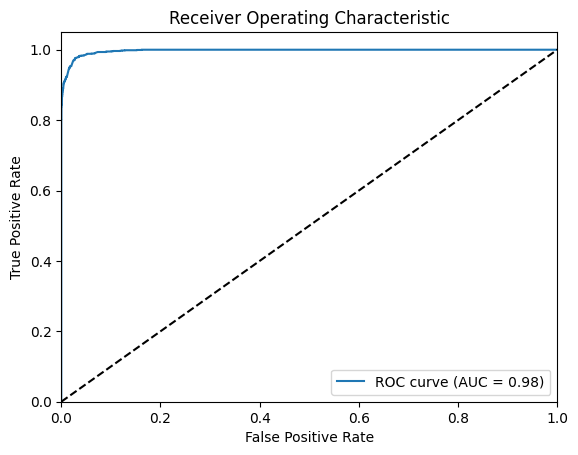

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Calculate the AUC score
auc_score = roc_auc_score(yval.reshape(1380,8), y_pred_prob.reshape(1380,8))

# Plot the ROC curve
fpr, tpr, _ = roc_curve(yval.ravel(), y_pred_prob.ravel())
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [ ]:
import numpy as np

# Assuming you have the one-hot encoded labels yval and the label encoder object label_encoder

# Convert one-hot encoded labels to integer indices
ypred_indices = np.argmax(y_pred, axis=1)

# Inverse transform the integer indices back to the original string labels
y_pred_decoded = label_encoder.inverse_transform(ypred_indices)

# Print the original string labels
print(y_pred_decoded)

['COPD' 'Asthma' 'Healthy' ... 'COPD' 'COPD' 'COPD']


In [ ]:
##Decoded Val
# Assuming you have the one-hot encoded labels yval and the label encoder object label_encoder

# Convert one-hot encoded labels to integer indices
yval_indices = np.argmax(yval, axis=1)

# Inverse transform the integer indices back to the original string labels
yval_decoded = label_encoder.inverse_transform(yval_indices)

# Print the original string labels
print(yval_decoded)

##Decoded Pred
# Assuming you have the one-hot encoded labels yval and the label encoder object label_encoder

# Convert one-hot encoded labels to integer indices
ypred_indices = np.argmax(y_pred, axis=1)

# Inverse transform the integer indices back to the original string labels
y_pred_decoded = label_encoder.inverse_transform(ypred_indices)

# Print the original string labels
print(y_pred_decoded)

['COPD' 'LRTI' 'Healthy' ... 'COPD' 'COPD' 'COPD']
['COPD' 'Asthma' 'Healthy' ... 'COPD' 'COPD' 'COPD']


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate metrics for each class
precision_scores = precision_score(yval_decoded, y_pred_decoded, average=None, zero_division=0)
recall_scores = recall_score(yval_decoded, y_pred_decoded, average=None)
f1_scores = f1_score(yval_decoded, y_pred_decoded, average=None)

In [ ]:
precision_scores

array([0.00694444, 0.9375    , 0.        , 0.98781549, 0.96153846,
       0.        , 0.84444444, 0.        ])

In [ ]:
# Assuming you have the precision_scores array and the label encoder object label_encoder

# Get the unique class labels
class_labels = label_encoder.classes_

# Create a dictionary to map class labels to precision scores
precision_scores_dict = dict(zip(class_labels, precision_scores))

# Print the precision score for each class
for label, score in precision_scores_dict.items():
    print(f"Precision for class {label}: {score}")

Precision for class Asthma: 0.006944444444444444
Precision for class Bronchiectasis: 0.9375
Precision for class Bronchiolitis: 0.0
Precision for class COPD: 0.9878154917319408
Precision for class Healthy: 0.9615384615384616
Precision for class LRTI: 0.0
Precision for class Pneumonia: 0.8444444444444444
Precision for class URTI: 0.0


In [ ]:
cnames= ["Asthma", "Bronchiectasis", "Bronchiolitis", "COPD", "Healthy", "LRTI", "Pneumonia", "URTI"]

In [ ]:
from sklearn.metrics import classification_report

# Assuming you have the true labels yval_decoded and the predicted labels y_pred_decoded

# Generate the classification report
report = classification_report(yval_decoded, y_pred_decoded)

# Print the report
print(report)

                precision    recall  f1-score   support

        Asthma       0.01      1.00      0.01         1
Bronchiectasis       0.94      0.71      0.81        21
 Bronchiolitis       0.00      0.00      0.00        32
          COPD       0.99      0.99      0.99      1150
       Healthy       0.96      0.39      0.56        64
          LRTI       0.00      0.00      0.00         6
     Pneumonia       0.84      0.67      0.75        57
          URTI       0.00      0.00      0.00        49

      accuracy                           0.88      1380
     macro avg       0.47      0.47      0.39      1380
  weighted avg       0.92      0.88      0.89      1380



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
yval.shape

(1380, 8)